# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

data = pd.read_csv("PS_20174392719_1491204439457_log.csv")
sample = data.sample(100000)

Features

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [4]:
sample.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,242.845210,1.778572e+05,8.328645e+05,8.544278e+05,1.088212e+06,1.210257e+06,0.001180,0.0
std,142.355275,5.254669e+05,2.890045e+06,2.926454e+06,3.303197e+06,3.581120e+06,0.034331,0.0
min,1.000000,1.360000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,155.000000,1.336377e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,238.000000,7.505349e+04,1.422350e+04,0.000000e+00,1.343171e+05,2.172005e+05,0.000000,0.0
75%,333.000000,2.080060e+05,1.060728e+05,1.438294e+05,9.451766e+05,1.115785e+06,0.000000,0.0
max,735.000000,4.950709e+07,3.440795e+07,3.447909e+07,2.123595e+08,3.114049e+08,1.000000,0.0


In [6]:
sample.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1465741,140,PAYMENT,24303.39,C1924075656,0.00,0.00,M2133950626,0.00,0.00,0,0
4780537,335,PAYMENT,42279.09,C1572987278,758483.99,716204.90,M1895281027,0.00,0.00,0,0
4316232,308,CASH_IN,231584.57,C954304401,6597985.70,6829570.27,C90454488,39883839.66,39652255.09,0,0
1892321,165,CASH_IN,119673.19,C609237530,2298349.95,2418023.13,C1762416578,1950911.86,1831238.67,0,0
2342801,189,DEBIT,3360.30,C2132525794,81147.00,77786.70,C105075751,186122.20,189482.50,0,0


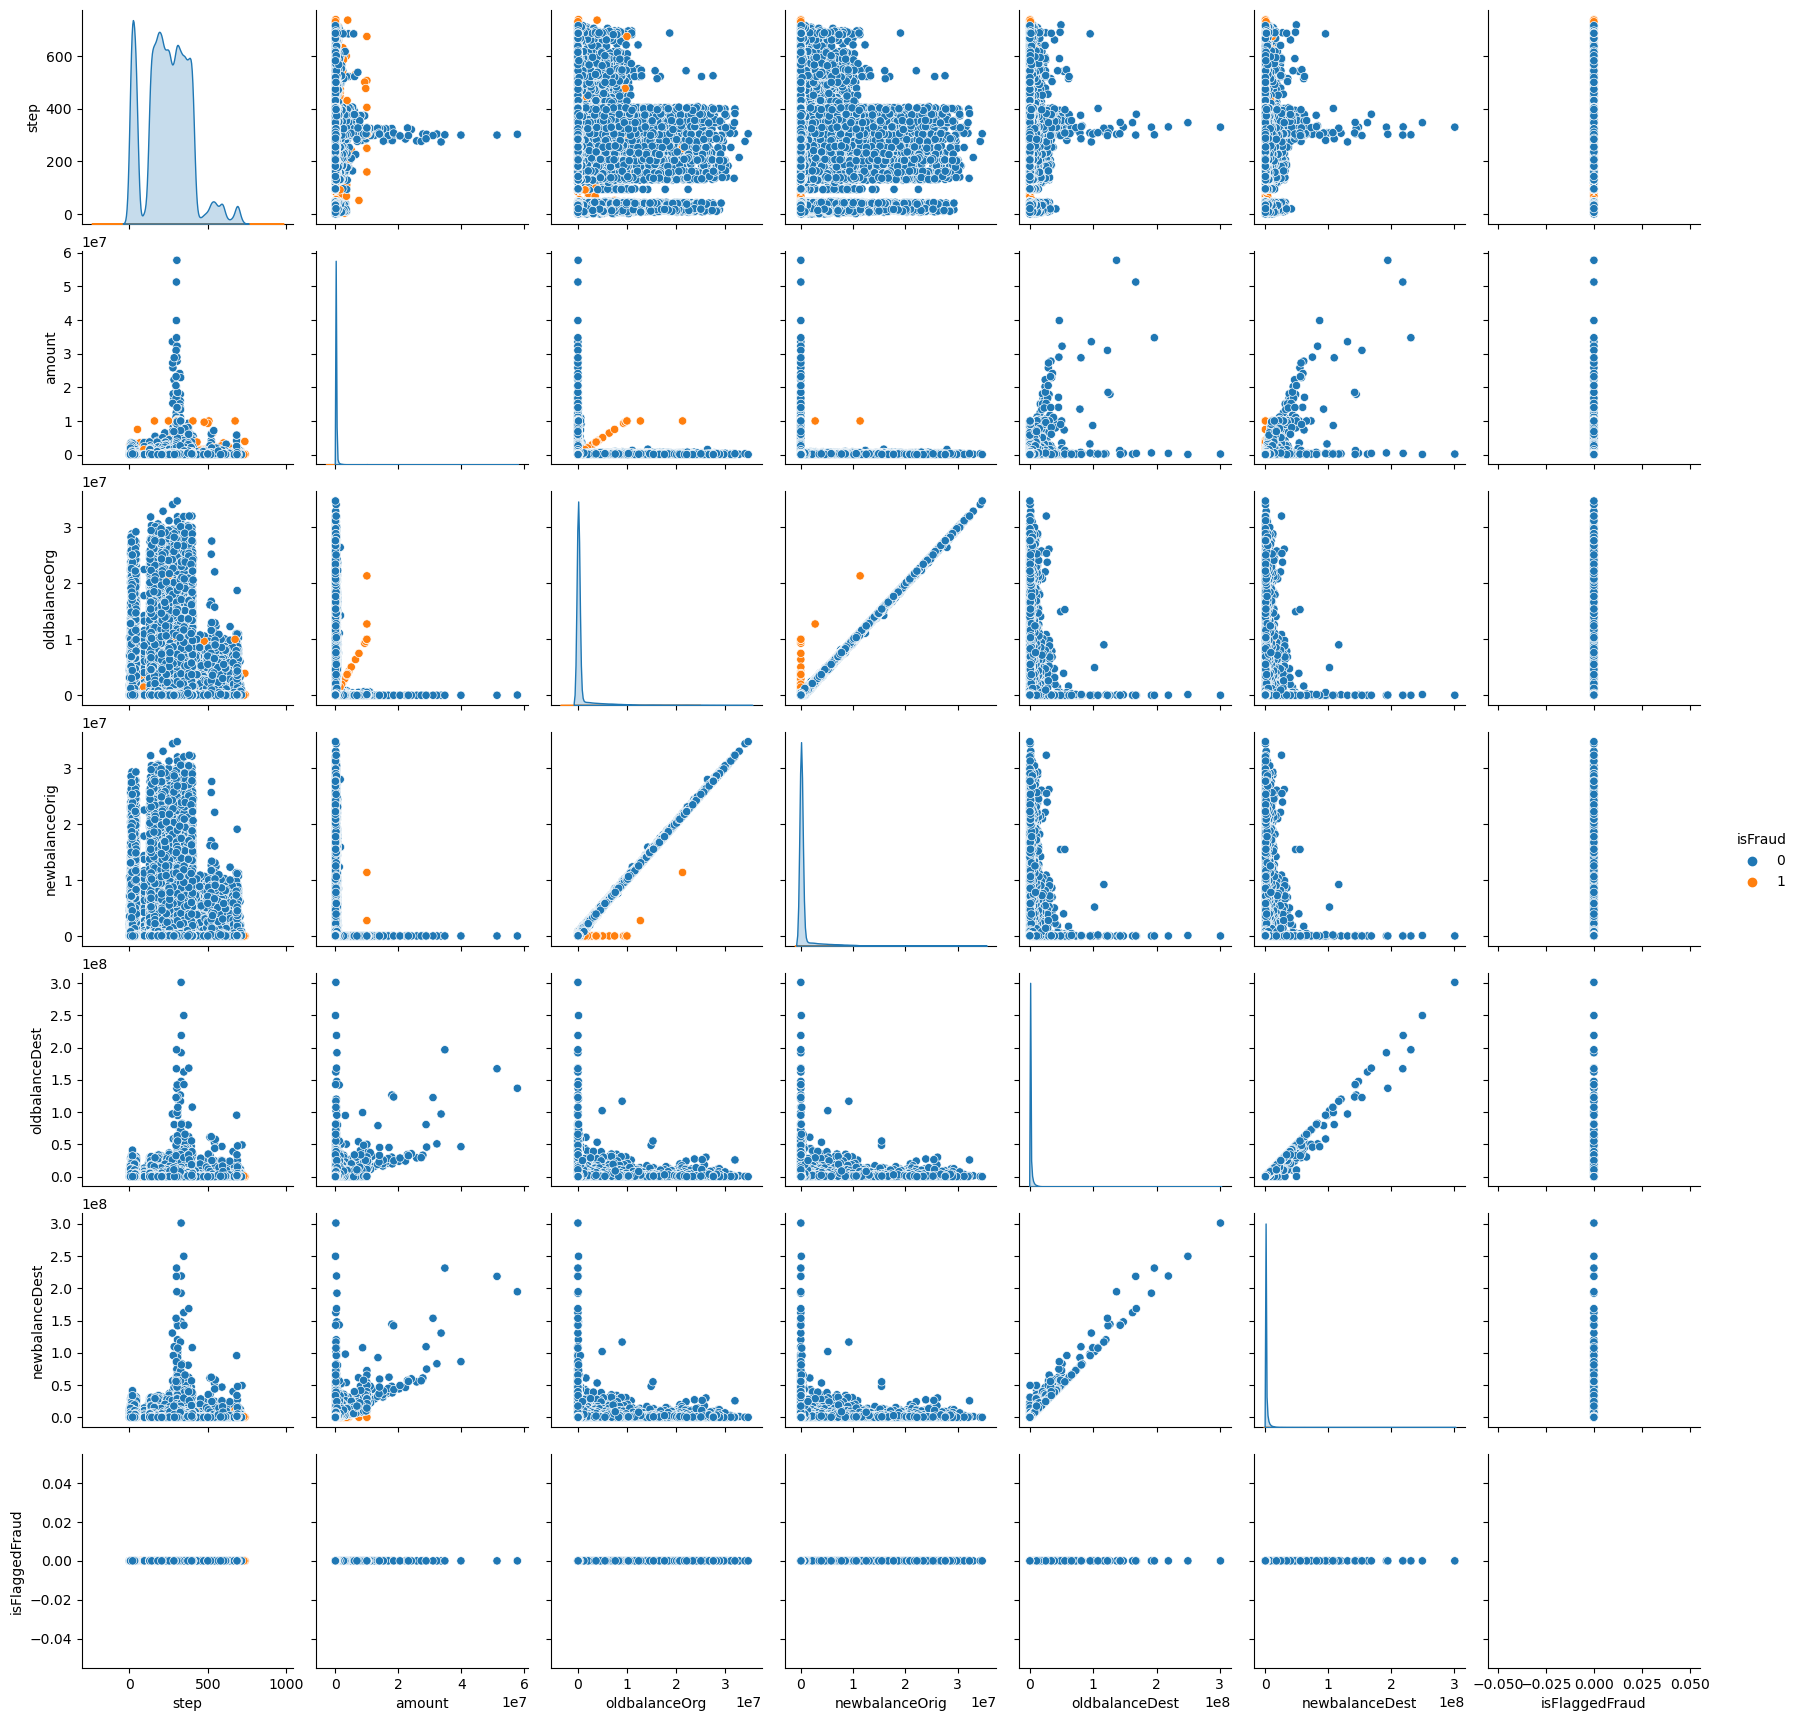

In [4]:
sns.pairplot(sample,hue = "isFraud")

/var/folders/5x/3x2kb92547q1q0l2kcqv0fpr0000gn/T/ipykernel_68562/3420852197.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


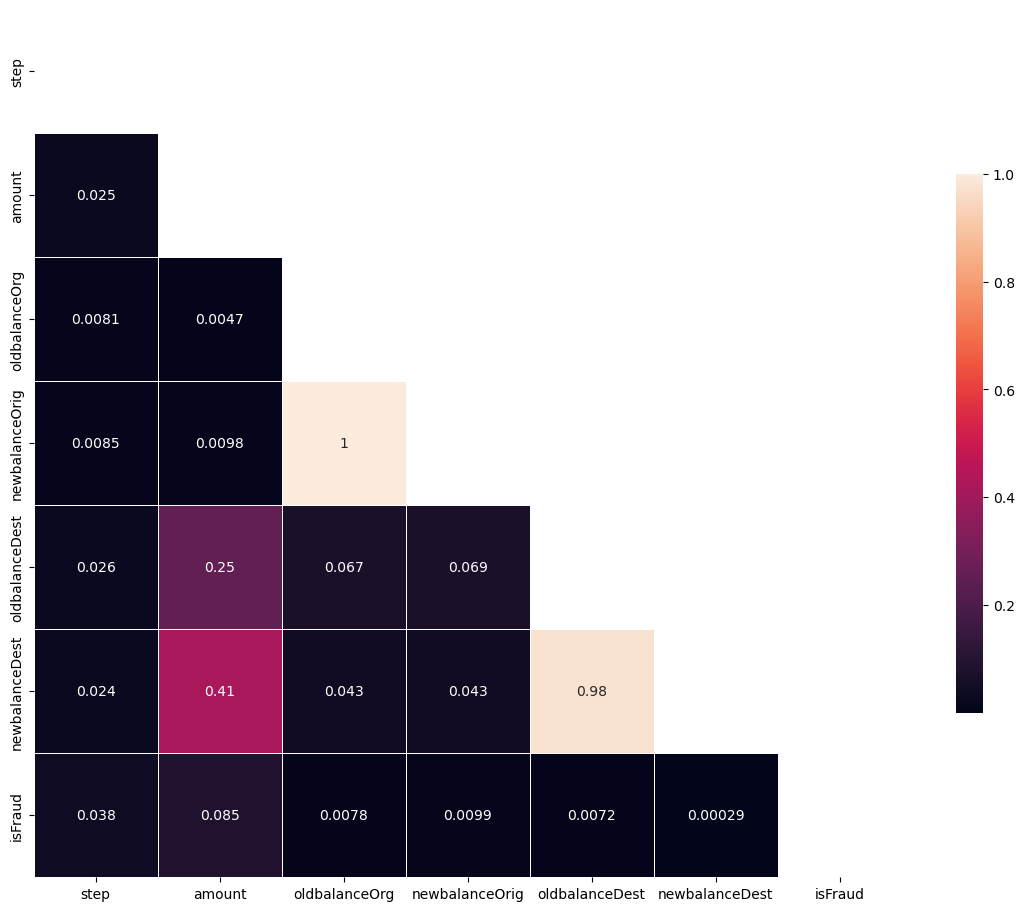

In [49]:
import numpy as np
corr=np.abs(sample.corr())
#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.show()

### What is the distribution of the outcome? 

<AxesSubplot:>

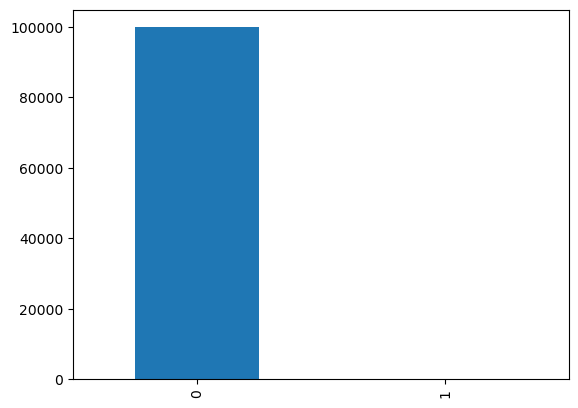

In [42]:
# Your response here
sample["isFraud"].value_counts().plot(kind="bar")

In [22]:
sample["isFraud"].value_counts()

0    99882
1      118
Name: isFraud, dtype: int64

In [28]:
sample["isFlaggedFraud"].value_counts()

0    100000
Name: isFlaggedFraud, dtype: int64

In [43]:
data["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [44]:
sample.drop(columns=["isFlaggedFraud"], inplace = True)

In [31]:
data["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [20]:
# Your code here
sample.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [26]:
sample.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [35]:
sample["step"].value_counts()

19     807
18     769
139    757
235    738
163    734
      ... 
30       1
649      1
572      1
730      1
71       1
Name: step, Length: 459, dtype: int64

In [36]:
#transform step variable from hour unit to day unit

In [50]:
sample["step"]=sample["step"]/24
sample["step"].value_counts()

0.000057    807
0.000054    769
0.000419    757
0.000708    738
0.000491    734
           ... 
0.000090      1
0.001956      1
0.001724      1
0.002200      1
0.000214      1
Name: step, Length: 459, dtype: int64

In [51]:
#transform type in dummies

In [53]:
type_dummies = pd.get_dummies(sample['type'], prefix='type')
sample = pd.concat([sample, type_dummies], axis=1)
sample.drop(columns =["type"],inplace = True)

In [55]:
sample.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
1465741,0.000422,24303.39,C1924075656,0.00,0.00,M2133950626,0.00,0.00,0,0,0,0,1,0
4780537,0.001010,42279.09,C1572987278,758483.99,716204.90,M1895281027,0.00,0.00,0,0,0,0,1,0
4316232,0.000928,231584.57,C954304401,6597985.70,6829570.27,C90454488,39883839.66,39652255.09,0,1,0,0,0,0
1892321,0.000497,119673.19,C609237530,2298349.95,2418023.13,C1762416578,1950911.86,1831238.67,0,1,0,0,0,0
2342801,0.000570,3360.30,C2132525794,81147.00,77786.70,C105075751,186122.20,189482.50,0,0,0,1,0,0


In [72]:
#Analyse if it's worth it to keep the variable nameOrig
print(len(sample["nameOrig"].unique()))
print(sample.shape)
print("It's not worth it to keep this columns because it has almost as many unique value as it has datapoints")
sample.drop(columns=["nameOrig"], inplace=True)

99995
(100000, 14)
It's not worth it to keep this columns because it has almost as many unique value as it has datapoints


In [78]:
#Analyse if it's worth it to keep the variable nameOrig
print(len(sample["nameDest"].unique()))
print(sample.shape)
print("It's not worth it to keep this column for the same reason as before")
sample.drop(columns=["nameDest"], inplace=True)

92878
(100000, 13)
It's not worth it to keep this column for the same reason as before


### Run a logisitc regression classifier and evaluate its accuracy.

In [79]:
# Your code here
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [80]:
from sklearn.model_selection import train_test_split

X = sample.drop(columns=["isFraud"])
y= sample["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [87]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train,y_train)
print("My test score is ", log_reg.score(X_test,y_test))
print("My train score is ", log_reg.score(X_train,y_train))
#The model is already very good and it doesn't overfit

My test score is  0.99776
My train score is  0.99756


In [91]:
from sklearn.metrics import classification_report, confusion_matrix
pred=log_reg.predict(X_test)
print(classification_report(y_test,pred))
#The recall is really good and it's important in this case

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24968
           1       0.36      0.94      0.52        32

    accuracy                           1.00     25000
   macro avg       0.68      0.97      0.76     25000
weighted avg       1.00      1.00      1.00     25000



### Now pick a model of your choice and evaluate its accuracy.

In [94]:
# Your code here
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators=100,
                            max_depth=3,
                            random_state=1)
forest.fit(X_train,y_train)
forest.score(X_test,y_test)

0.99888

In [95]:
pred=forest.predict(X_test)
print(classification_report(y_test,pred))
#The recall is really good and it's important in this case

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24968
           1       1.00      0.12      0.22        32

    accuracy                           1.00     25000
   macro avg       1.00      0.56      0.61     25000
weighted avg       1.00      1.00      1.00     25000



### Which model worked better and how do you know?

In [96]:
# Your response here
print("Both models work very well!")

Both models work very well!


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.